In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from malnis import show
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, SparsePCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, PrecisionRecallDisplay, RocCurveDisplay
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import pytorch_lightning as pl
import torch.utils.data as tud
import seaborn as sns
sns.set()

In [14]:
pwd

'/home/jarobyte/malnis_dataset/notebooks'

In [15]:
# The number of sentences in each paper goes from 59 to 4,447. I truncate to 512.

data = pd.read_pickle("../data/labels.pkl")\
.reset_index(drop = True)\
.assign(n_sentences = lambda df: df.sentences.map(len))\
.assign(
    sentences = lambda df: df.sentences.map(lambda y: y[:512]),
    relevance = lambda df: df.relevance.map(lambda y: y[:512]),    
)

show(data)

(8965, 9)


,query,document,summary,r1,r2,rl,sentences,relevance,n_sentences
0,We introduce a new language representation mod...,"KEYWORDS cascade ranking, pre-trained language...",[Our approach is mainly based on the BERT lang...,0.237885,0.065359,0.229075,"[KEYWORDS cascade ranking, pre-trained languag...","[False, False, False, False, False, False, Fal...",117
1,The dominant sequence transduction models are ...,"KEYWORDS cascade ranking, pre-trained language...",[BERT [2] is a self-supervised approach for pr...,0.238372,0.063366,0.215116,"[KEYWORDS cascade ranking, pre-trained languag...","[False, False, False, False, False, True, Fals...",117
2,Language model pretraining has led to signific...,"KEYWORDS cascade ranking, pre-trained language...","[Recently, some variants [4, 12] of BERT langu...",0.172727,0.047782,0.172727,"[KEYWORDS cascade ranking, pre-trained languag...","[False, False, False, False, False, True, Fals...",117
3,With the capability of modeling bidirectional ...,"KEYWORDS cascade ranking, pre-trained language...","[Recently, some variants [4, 12] of BERT langu...",0.237838,0.078740,0.227027,"[KEYWORDS cascade ranking, pre-trained languag...","[False, False, False, False, False, False, Tru...",117
4,Neural sequence-to-sequence models have provid...,"KEYWORDS cascade ranking, pre-trained language...",[The proposed model is based on the pointer-ge...,0.215139,0.093023,0.199203,"[KEYWORDS cascade ranking, pre-trained languag...","[False, False, False, False, False, False, Fal...",117


In [16]:
s = np.array(data.relevance.map(lambda x: [sum(x), len(x)]).tolist()).sum(axis = 0)
s[0] / s[1]

0.03491795433209077

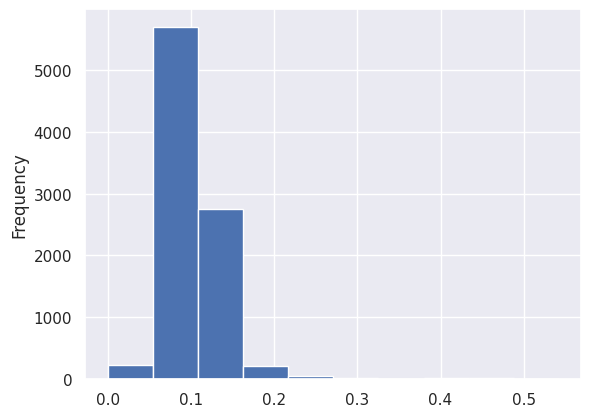

In [17]:
data.r2.plot.hist(
#     log = True
)
plt.show()

In [18]:
data["query"][36]

'The recently proposed BERT has shown great power on a variety of natural language understanding tasks, such as text classification, reading comprehension, etc. However, how to effectively apply BERT to neural machine translation (NMT) lacks enough exploration. While BERT is more commonly used as fine-tuning instead of contextual embedding for downstream language understanding tasks, in NMT, our preliminary exploration of using BERT as contextual embedding is better than using for fine-tuning. This motivates us to think how to better leverage BERT for NMT along this direction. We propose a new algorithm named BERT-fused model, in which we first use BERT to extract representations for an input sequence, and then the representations are fused with each layer of the encoder and decoder of the NMT model through attention mechanisms. We conduct experiments on supervised (including sentence-level and document-level translations), semi-supervised and unsupervised machine translation, and achi

In [19]:
[s for s, l in zip(data.sentences[36], data.relevance[36]) if l == True]

['BERT (Devlin et al., 2019) and its improvements to natural language understanding have spurred a rapid succession of contextual language representations (Yang et al., 2019; Liu et al., 2019; inter alia) which use larger datasets and more involved training schemes.',
 'Existing uses of pretrained MLMs in sequenceto-sequence models for automatic speech recognition (ASR) or neural machine translation (NMT) involve integrating their weights (Clinchant et al., 2019) or representations (Zhu et al., 2020) into the encoder and/or decoder during training.',
 'We tune the LM weight λ on the development set to minimize word error rate (WER) for ASR or maximize tokenized BLEU for NMT.',
 'We finetune BERT to produce scores without [MASK] tokens.',
 'In particular, we see the outsized cost of the unconditional first unigram in Figure 3.',
 'Furthermore, neither work considers the inference cost of masked rescoring, which we address with our maskless scoring approach, or analyze PLL’s numerical pr

In [20]:
sum(data.relevance[36])

9

In [21]:
len(data.relevance[36])

258

In [22]:
model = SentenceTransformer(
    "sbert"
#     'all-MiniLM-L6-v2', 
#     cache_folder = "../assets"
#     "../cache/huggingface/transformers/"
#     cache_folder = "../cache/huggingface/transformers"
)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [23]:
# query_embeddings = model.encode(data["query"])
# query_embeddings.shape

# dims = query_embeddings.shape[1]
# sentence_embeddings = [
#     model.encode(l)#.toarray() 
#     for l in tqdm(data.sentences)
# ]
# print(all([l.shape[1] == dims for l in sentence_embeddings]))

# print(query_embeddings.shape[0] == len(sentence_embeddings))

# print(sum([len(l) for l in tqdm(data.sentences)]))

# train = [
# #     ((sp.csr_matrix(np.ones([l.shape[0],1])) * q) - l).power(2)
# #     (q - l)**2
#     np.concatenate([np.tile(q, (l.shape[0], 1)), l], axis = 1)
#     for q, l in zip(tqdm(query_embeddings), sentence_embeddings)
# ]
# print(len(train))

# X = [torch.tensor(x) for x in train]
# print(all([x.shape[0] <= 512 for x in X]))

# X = torch.nn.utils.rnn.pad_sequence(X, batch_first = True)
# print(X.shape)

# # X = np.concatenate(train)#.toarray().T#.squeeze()
# # print(X.shape)

# torch.save(X, "X_lstm_sbert_concat.pt")

In [24]:
X = torch.load("X_lstm_sbert_concat.pt")
X.shape

torch.Size([8965, 512, 768])

In [25]:
# Y = torch.tensor([y for l in tqdm(data.relevance) for y in l])
# Y.shape

In [26]:
Y = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(x) for x in data.relevance], 
    batch_first = True
)\
.long()
Y.shape

torch.Size([8965, 512])

In [27]:
Y.sum()

tensor(91349)

In [28]:
X_train, X_test, Y_train, Y_test, relevance_train, relevance_test = train_test_split(
    X, 
    Y, 
    data.relevance, 
    random_state = 1
)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("Y_train", Y_train.shape)
print("Y_test", Y_test.shape)

X_train torch.Size([6723, 512, 768])
X_test torch.Size([2242, 512, 768])
Y_train torch.Size([6723, 512])
Y_test torch.Size([2242, 512])


In [29]:
Y_train.sum(), Y_test.sum()

(tensor(68550), tensor(22799))

In [30]:
dataset = tud.TensorDataset(X_train.cuda(), Y_train.cuda())
len(dataset)

6723

In [31]:
loader = tud.DataLoader(
    dataset,
    batch_size = 8,
    shuffle = True
)
[x.shape for x in next(iter(loader))]

[torch.Size([8, 512, 768]), torch.Size([8, 512])]

parameters: 11,033,857


  0%|          | 0/2523 [00:00<?, ?it/s]

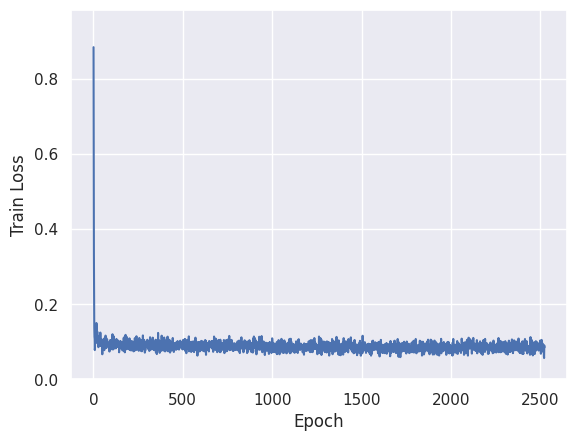

  0%|          | 0/141 [00:00<?, ?it/s]

true predictions (656761,)
true targets (656761,)


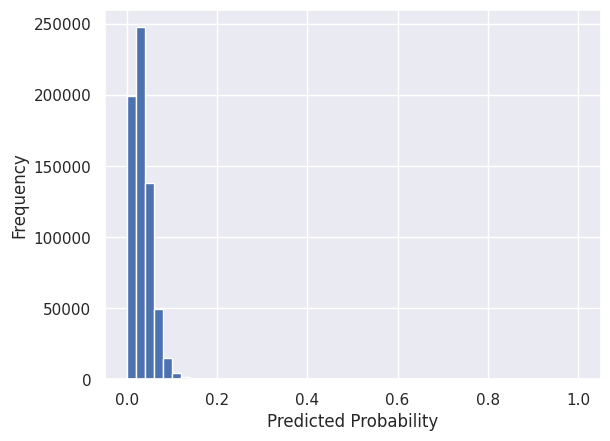

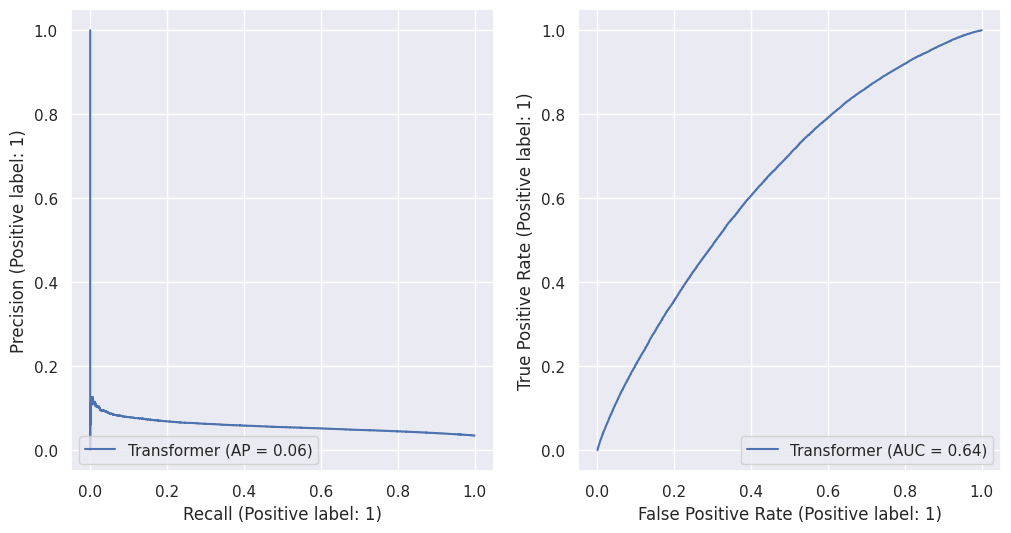

In [33]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.positional_embeddings = nn.Embedding(
            512, 
            768
        )        
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model = 768,
            dim_feedforward = 768,
            nhead = 4
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer = self.transformer_layer,
            num_layers = 2
        )
        self.out_layer = nn.Linear(768, 1)
        
    def forward(self, x):
        x_positional = torch.arange(
            x.shape[1], 
            device = next(self.parameters()).device
        )\
        .repeat((x.shape[0], 1))
        x_positional = self.positional_embeddings(x_positional)
#         print("X", x.shape)
#         print("X_positional", x_positional.shape)
        x = (x + x_positional).transpose(0, 1)
#         print("x", x.shape)
        x = self.encoder.forward(src = x).transpose(0, 1)
        
#         x, (last_hidden, last_memory) = self.lstm(x)
# #         print(x)
        return self.out_layer(x).sigmoid()
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr = 10**-4)
#         return optimizer
    
#     def training_step(self, train_batch, batch_idx):
#         x, y = train_batch
#         x = self.forward(x)

    
clf = Transformer()
clf.cuda()
print(f"parameters: {sum([x.numel() for x in clf.parameters()]):,}")    

clf.cuda()
clf.train()

epochs = 3
lr = 10 ** -4

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr = lr)
bar = tqdm(total = epochs * len(loader))
plot = []
for i in range(1, epochs + 1):
    losses = []
    for x, y in (iter(loader)):
        preds = clf(x).squeeze()
#         print(preds.shape)
#         print(y.shape)
        loss = criterion(preds, y.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        plot.append(loss.item())
        bar.update(1)
    epoch_loss = sum(losses) / len(losses)
#     plot.append(epoch_loss)
    print(f"epoch {i}, loss {epoch_loss:.6f}", end = "\r")

plt.plot(np.arange(len(plot)) + 1, plot)
plt.ylim(0, max(plot) + 0.1)
plt.ylabel("Train Loss")
plt.xlabel("Epoch")
plt.show()

# results

test_dataset = tud.TensorDataset(X_test.cuda())
test_loader = tud.DataLoader(test_dataset, batch_size = 16)
predictions = []
for (b,) in tqdm(test_loader):
    p = clf(b).cpu().detach().numpy().squeeze()
    predictions.append(p)
predictions = np.concatenate(predictions)
predictions.shape

# predictions = clf(X_test.cuda()).cpu().detach().numpy().squeeze()
# predictions.shape

relevance_test.map(len).sum()

true_predictions = np.concatenate(
    [
        p[:len(l)] 
        for p, l in zip(
            predictions, 
            relevance_test
        )
    ]
)

print("true predictions", true_predictions.shape)

true_targets = np.concatenate(relevance_test.to_list())
print("true targets", true_targets.shape)

plt.hist(true_predictions, range = (0, 1), bins = 50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

display = PrecisionRecallDisplay.from_predictions(
    true_targets, true_predictions, name = "Transformer",
    ax = axes[0]
)

display = RocCurveDisplay.from_predictions(
    true_targets, true_predictions, name = "Transformer",
    ax = axes[1]
)